# **1. Getting Started with Data**

### **1.1 Data Description**

For this Case Study, we will use an experimental data of bearing condition monitoring collected by Paderborn University, Germany [1].

The dataset collected is the result of 32 experiments based on varying operating and health conditions.

Number of experiements for the respective health states:
*   Healthy Bearings: 6 bearings
*   Real Damages: 14 bearings
*   Aritificial Damages: 12 bearings

Health conditions:
1. Healthy (undamaged) -- 0
2. Outer race faults -- 1
3. Inner race faults -- 2

Operating Conditions:
1.   **Rotation Speed: 1500 rpm, Load: 0.7 Nm, Radial Force: 1000 N**
2.   Rotation Speed: 900 rpm, Load: 0.7 Nm, Radial Force: 1000 N
3.   Rotation Speed: 1500 rpm, Load: 0.1 Nm, Radial Force: 1000 N
4.   Rotation Speed: 1500 rpm, Load: 0.7 Nm, Radial Force: 400 N

For demonstration, we will consider a subset of this data used by Zhang et al in their research work [2], i.e., the first operating condition, also termed as FD-A dataset. To pre-process the data, they followed the procedure released by Eldele et a [3].

**Related Materials:**

1. Christian Lessmeier, James Kuria Kimotho, Detmar Zimmer, and Walter Sextro. Condition monitoring of bearing damage in electromechanical drive systems by using motor current signals of electric motors: A benchmark data set for data-driven classification. In European conference of the prognostics and health management society, 2016.
2. Xiang Zhang, Ziyuan Zhao, Theodoros Tsiligkaridis, and Marinka Zitnik. Self-Supervised Contrastive Pre-Training For Time Series via Time-Frequency Consistency. (NeurIPS 2022), New Orleans, USA, November 28 - December 3, 2022.
3.  Emadeldeen Eldele, Mohamed Ragab, Zhenghua Chen, Min Wu, Chee Keong Kwoh, Xiaoli Li, and Cuntai Guan. Time-series representation learning via temporal and contextual contrasting. In IJCAI, pages 2352–2359, 2021.

### **1.2 Data Download**

The pre-process data is hosted on https://figshare.com/ndownloader/articles/19930205/versions/1.

We can download the zip file and unzip it to a folder named FD-A. The extracted folder should contain train, val and test files.

In [1]:
!pip install wget
!wget -O FD-A.zip https://figshare.com/ndownloader/articles/19930205/versions/1
!unzip  FD-A.zip -d /content/FD-A

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=6605ebcc4f631ece811d67a9aadb59f0f2147a2dafbe6518b6a7042d5ac06379
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
--2023-07-15 14:53:21--  https://figshare.com/ndownloader/articles/19930205/versions/1
Resolving figshare.com (figshare.com)... 52.16.104.164, 34.246.75.240, 2a05:d018:1f4:d000:f1c1:eae9:f902:8f58, ...
Connecting to figshare.com (figshare.com)|52.16.104.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 964815105 (920M) [application/zip]
Saving to: ‘FD-A.zip’

FD-A.zip            100%[===================>] 920.12M  28.3MB/s    in 34s     

2023-07-15 14:53:56 (27.3 MB/s) - ‘FD-A.zip’ saved [964815105/964815105]

Archive:  FD-A.zip
 extracting: /content/FD-A/test.pt   
 extracting: /content/FD-A/train.pt  
 extracting: /content/FD-A/val.pt    


### **1.3 Data Load**

Now that we have downloaded the required data, we will load and start our exploration.

**Note** that the extension of the loaded files is **.pt**; therefore, we will import a torch to load these files.



In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from tqdm import tqdm
import pandas as pd

In [3]:
train = torch.load("/content/FD-A/train.pt")
test = torch.load("/content/FD-A/test.pt")
val = torch.load("/content/FD-A/val.pt")

### **1.4 Understanding Data**

In [58]:
def visualize_vibration_signal(dataset):
  '''Function to visualize vibration signals given the dataset dict.'''

  labels = dataset['labels'].detach().cpu().numpy()
  samples = np.squeeze(dataset['samples'], axis=1)

  # Sample spacing, we know that the sampling frequency is 64kHz, the length is 5120
  T = 1.0 / 64000.0
  x = np.linspace(0.0, 5120*T, 5120)

  # Plot samples from all classes
  fig, axes = plt.subplots(1, 3, figsize=(15, 3))
  for i, ax in zip(range(3), axes):
    # Collect a sample from the required class
    index = np.where(labels==i)[0][0]
    ax.plot(x, samples[index])
    ax.set_title("Health type {}".format(i))
    ax.set_xlabel("Time (in seconds)")
    ax.set_ylim([-5,5])

def visualizing_fft(dataset, th=10000):
  '''Function to visualize fft given the dataset dict.'''

  labels = dataset['labels'].detach().cpu().numpy()
  samples = np.squeeze(dataset['samples'], axis=1)

  # Sample spacing, we know that the sampling frequency is 64kHz, the length is 5120
  T = 1.0 / 64000.0
  x = np.linspace(0.0, 5120*T, 5120)
  N = 5120

  # Plot samples from all classes
  fig, axes = plt.subplots(1, 3, figsize=(15, 3))
  for i, ax in zip(range(3), axes):
    # Collect a sample from the required class
    index = np.where(labels==i)[0][0]

    # Subtract with mean to avoid peak at a frequency of zero
    y = samples[index] - np.mean(samples[index])
    y_fft =np.fft.fft(y)
    y_fft =  2*np.abs(y_fft)
    #y_psd = y_fft * np.conj(y_fft) / N
    freq = (1/(T*N))*np.arange(N)
    pos_ind = np.arange(1, np.floor(N/2), dtype=np.int32)

    ax.plot(freq[pos_ind], y_fft[1:int(N/2)]/len(freq[pos_ind]))
    ax.set_title("Health type {}".format(i))
    ax.set_xlabel("Frequency")
    #ax.set_ylim([0,0.05])
    if i==0:
      ax.set_ylabel('Amplitude')

def visualizing_stft(dataset):
  '''Function to visualize stft given the dataset dict.'''

  labels = dataset['labels'].detach().cpu().numpy()
  samples = np.squeeze(dataset['samples'], axis=1)

  # Sample spacing, we know that the sampling frequency is 64kHz, the length is 5120
  T = 1.0 / 64000.0
  x = np.linspace(0.0, 5120*T, 5120)
  N = 5120

  # Plot samples from all classes
  fig, axes = plt.subplots(1, 3, figsize=(15, 3))
  for i, ax in zip(range(3), axes):
    # Collect a sample from the required class
    index = np.where(labels==i)[0][0]

    # Subtract with mean to avoid peak at a frequency of zero
    f, t, Zxx = signal.stft(samples[index], 64000, nperseg=512)

    ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud')
    ax.set_title("Health type {}".format(i))
    ax.set_xlabel("Time (in seconds)")
    if i==0:
      ax.set_ylabel('Frequency [Hz]')
    ax.set_ylim([0,5000])

**Visualizing Train Set**

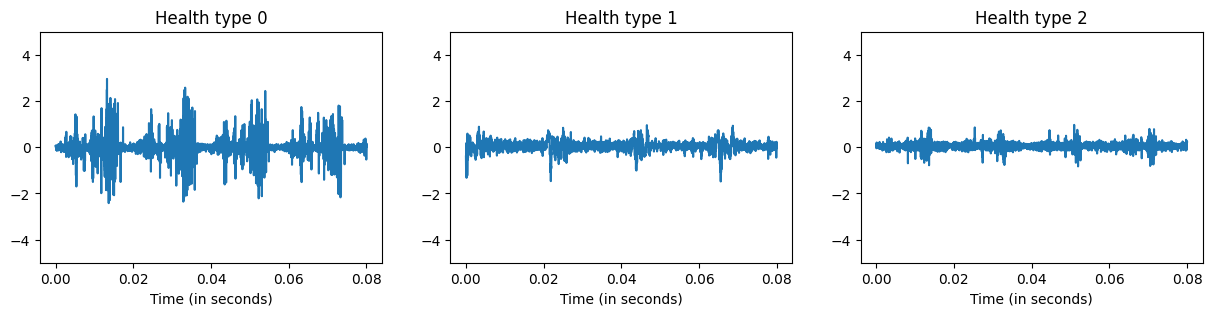

In [59]:
visualize_vibration_signal(train)

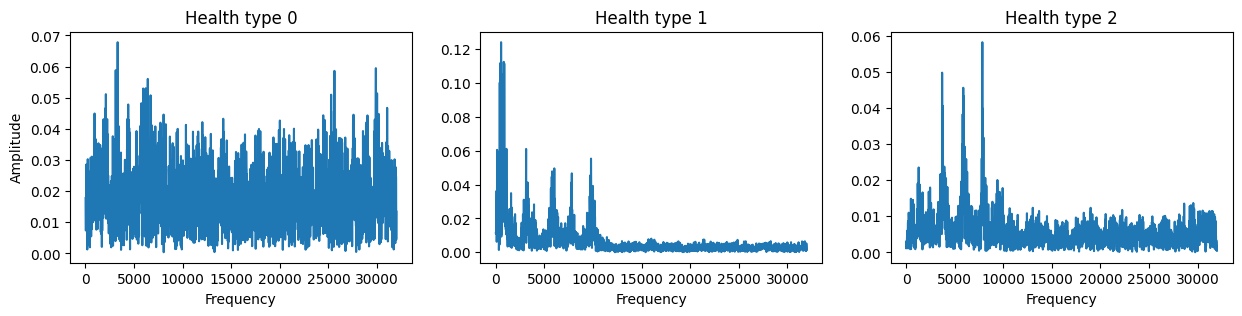

In [60]:
visualizing_fft(train)

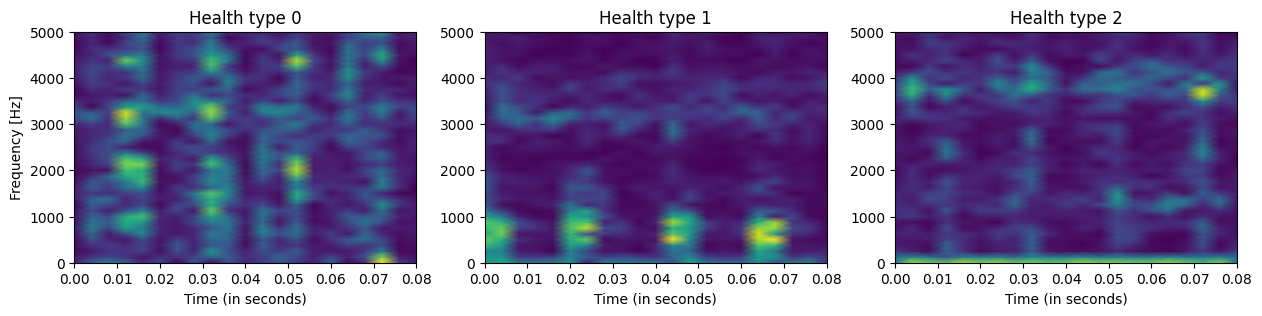

In [61]:
visualizing_stft(train)

#### **1.4.1 Time Domain Analysis**

* **Challenging to analyze fault levels directly from vibration signals:** Vibration signals are collected in the time domain, and it usually comprises of several sources such as the responses from rotating components and environmental noise.
* **Feature Extraction:** Extract features based on three main techniques: time-domain, frequency-domain, time-frequency domain.

In this case study, we will focus on some of the most popular features regularly used in fault diagnosis literature.

1. **Root Mean Square Amplitude:** $RMS = \sqrt{\frac{1}{T}\int |x(t)^2| \, \mathrm{d}t}$

2. **Variance:** $ var = σ_x^2 = \dfrac{\sum_{i=1}^{n} (x_i-\bar{x})^2}{n-1} \\ $

3. **Peak value:** $PvT = \max(|x_i|) \\ $

4. **Crest factor:** $CF = \dfrac{PvT}{RMS} \\ $

5. **Kurtosis:** $Kurt = \dfrac{\sum_{i=1}^{n}(x_i-\bar{x})^4}{n\times var^2} \\ $

6. **Clearance factor:** $Clf = \dfrac{PvT}{\left(\frac{1}{n}\sum_{i=1}^{n}\sqrt{|x_i|}\right)^2} \\ $

7. **Impulse factor:** $IF = \dfrac{PvT}{\frac{1}{n}\sum_{i=1}^{n}|x_i|} \\ $

8. **Shape factor:** $SF = \dfrac{RMS}{\frac{1}{n}\sum_{i=1}^{n}|x_i|} \\ $

9. **Line Integral:** $LI = \sum_{i=1}^{n}|x_{i+1} - x_i| \\ $

10. **Peak-to-Peak value:** $PP = \max(x_i) - \min(x_i) \\ $

11. **Shannon entropy:** $Ent = -\sum_{i=1}^{n}x_i^2\log(x_i^2) \\ $

12. **Skewness:** $ Sk = \dfrac{\frac{1}{n}\sum_{i=1}^{n}{(x_i-\bar{x})^3}}{\left(\sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_i-\bar{x})^2}\right)^2} \\ $

13. to 17. **Higher Moments:**

>*   $HM_p = \dfrac{\sum_{i=1}^{n}(x_i-\bar{x})^p}{n\times \sqrt{var}^p} \\ $, for all p more than 4.






#### **1.4.2 Frequency Domain Analysis**

*   **Time domain signal is composed of several frequencies.** Frequency analysis is widely used as it gives a clear picture of dominant frequencies in the signal, which can be used for fault diagnosis.
*   **Fourier Analysis** is employed to get the frequency representations of the vibration signals. Mainly three categories: Fourier Series, continuos Fourier Transform (DCT), discrete Fourier Transform (DFT).

We won't dive deep into the mathematics of these methods. Instead, we will focus on creating features relevant to our problem, especially the features that can be added with the ones we created in the previous section.

18. **Peak value of FFT:** $ PvF = \max(r_k), r_k = \sum_{i=-∞}^{∞} x(t)e^{-iwt} \\ $

19. **Energy of FFT:** $ En = \sum_{k=1}^{n} r_k \\ $

20. **Power spectral density of FFT:** $ PSD = \sum_{i=-∞}^{∞} r_k e^{-iwk} \\ $



#### **1.4.3 Time-Frequency Domain Analysis**

Fourier transform is an effective technique for fault diagnosis; however, when the signal is **non-stationary**, it is not eady to identify existing faults. Additionally, it is assumed that the frequencies present in the signal are constant over time, which falls flat when we deal with non-stationary signals.

Popular time-frequency domain methods are:

*   STFT, short-time Fourier Transform
*   WT, wavelet transform
*   HHT, Hilbert-Huang transform
*   EMD, empirical mode decomposition
*   WPD, wavelet packet decomposition, etc.

We will try appending features from these methods to our exisiting list. If time allows, we will try experimenting deep learning techniques with the STFT or wavelet transform features later on.

21. **Energy of WPD detail coefficient one:** $ D_1 = \sum_{i=1}^{n1} cD1_i \\ $
22. **Energy of WPD detail coefficient two:** $ D_2 = \sum_{i=1}^{n2} cD2_i \\  $
23. **Energy of WPD detail coefficient three:** $ D_3 = \sum_{i=1}^{n3} cD3_i \\  $
24. **Energy of WPD approximate coefficient three:** $ A_3 = \sum_{i=1}^{n3} cA3_i \\  $

# **2. Feature Engineering:**


### **2.1 Helper functions**

In [91]:
from math import pi
def norm_pdf(x, mu, var):
  return (1/np.sqrt(var*2*pi))*np.exp(-(x-mu/(2*var))**2)

def cal_feat(x, y):
  ''' calculates the required features for a given signal '''

  # Normal PDF for the given signal for its use in calculating entropy
  px = norm_pdf(x, np.mean(x), np.var(x))

  # Dictionary of relevant features
  dict_feat = {
      # time-domain features
      'x_rms' : np.sqrt(np.mean(x**2)),
      'x_var' : np.var(x),
      'x_pvt' : np.max(np.abs(x)),
      'x_cf' : np.max(np.abs(x))/np.sqrt(np.mean(x**2)),
      'x_kurt' : np.mean((x-np.mean(x))**4)/np.var(x)**2,
      'x_clf' : np.max(np.abs(x))/(np.mean(np.sqrt(np.abs(x))))**2,
      'x_if' : np.max(np.abs(x))/np.mean(np.abs(x)),
      'x_sf' : np.sqrt(np.mean((x - np.mean(x).reshape(-1,1))**2))/np.mean(np.abs(x)),
      'x_li' : np.sum(np.abs(x[1:] - x[:-1])),
      'x_pp' : np.max(x) - np.min(x),
      'x_ent' : -np.sum(np.multiply((px**2),(np.log(px**2)))),
      'x_sk' : stats.skew(x),
      'x_hm5' : np.mean((x-np.mean(x))**5)/np.var(x)**(5/2),
      'x_hm6' : np.mean((x-np.mean(x))**6)/np.var(x)**(6/2),
      'x_hm7' : np.mean((x-np.mean(x))**7)/np.var(x)**(7/2),
      'x_hm8' : np.mean((x-np.mean(x))**8)/np.var(x)**(8/2),
      'x_hm9' : np.mean((x-np.mean(x))**9)/np.var(x)**(9/2),
      'target' : y,

      # frequency-domain features, will be explored later
      # time-frequency features, will be explored later
      }

  return dict_feat

def extract_features(dataset):
  ''' Function to store the features of every signal in a dataframe '''
  feat_df = pd.DataFrame()
  labels = dataset['labels'].detach().cpu().numpy()
  samples = np.squeeze(dataset['samples'], axis=1)

  for i in tqdm(range(len(labels))):
    temp = cal_feat(samples[i], labels[i])
    feat_df = pd.concat([feat_df, pd.DataFrame.from_records([temp])])

  return feat_df

### **2.2 Extract features**

The next step is to calculate the features for all the data splits.

In [92]:
train_df = extract_features(train)

100%|██████████| 8184/8184 [00:22<00:00, 358.40it/s]


In [93]:
val_df = extract_features(val)

100%|██████████| 2728/2728 [00:07<00:00, 368.67it/s]


In [94]:
test_df = extract_features(test)

100%|██████████| 2728/2728 [00:09<00:00, 302.17it/s]


Sample Dataframe:

In [98]:
display(train_df)

,x_rms,x_var,x_pvt,x_cf,x_kurt,x_clf,x_if,x_sf,x_li,x_pp,x_ent,x_sk,x_hm5,x_hm6,x_hm7,x_hm8,x_hm9,target
0,0.216361,0.045199,1.483154,6.854986,9.121544,12.503216,9.913112,1.420975,417.996216,2.438354,-12046.002532,-0.838466,-29.909991,211.118170,-1069.927809,6957.954841,-41398.701009,1
0,0.204181,0.041627,2.590942,12.689456,27.624492,26.827844,20.884204,1.644560,676.031494,5.075073,-23584.136477,-0.172448,-37.778544,2470.394947,-6080.774469,311503.942604,-965495.899044,1
0,0.141753,0.018208,0.967407,6.824609,9.601855,11.799485,9.569586,1.334787,437.490844,1.797485,569.797104,-0.064496,-3.316395,227.899652,-117.266165,6981.794270,-3735.306810,2
0,0.364368,0.132518,2.957153,8.115846,18.148515,27.035536,17.097073,2.104674,1396.697997,5.377197,-735.265336,0.159726,10.998801,533.923994,712.496342,19536.158306,45127.178894,0
0,0.255099,0.063354,1.330566,5.215877,5.535221,9.140139,7.278015,1.376776,456.228637,2.359009,-7470.387716,-0.507790,-9.042569,59.575614,-167.029758,925.884522,-3460.596057,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.370268,0.136834,3.915405,10.574506,20.841887,34.319970,21.964183,2.075082,1432.226562,7.019043,-511.626428,-0.209345,-18.855217,925.757988,-2278.693479,61772.456295,-275385.561813,0
0,0.155122,0.021982,1.251221,8.066048,12.655042,14.496871,11.709320,1.387489,488.693237,2.478027,-1478.737101,0.318487,9.793459,400.363471,182.954158,17533.738704,-6277.063046,2
0,0.111932,0.010989,0.939941,8.397466,16.692156,15.356038,12.346236,1.376932,332.415771,1.824951,586.389596,-0.174551,-3.041128,693.216030,-35.500454,37637.563386,-1425.329929,1
0,0.117043,0.011890,1.101685,9.412667,15.416730,16.903958,13.681024,1.354095,346.667480,1.974487,557.440063,0.080067,6.289234,627.912919,754.317005,36094.085790,88133.768738,1


### **2.2 Save features**

Now that we have the features in the form of dataframe, we will save it to csv format for its use in later notebooks.

In [99]:
train_df.reset_index(drop=True).to_csv('train_df.csv', index=False)
val_df.reset_index(drop=True).to_csv('val_df.csv', index=False)
test_df.reset_index(drop=True).to_csv('test_df.csv', index=False)